# Natural Language Processing

This dataset is one of the excellent [UCI datasets](https://archive.ics.uci.edu/ml/datasets.html).

In [1]:
sms = [line.rstrip() for line in open('SMSSpamCollection')]

How many messages are contained in this dataset?

In [2]:
len(sms)

5574

Let's take a look at an arbitrary message.

In [3]:
sms[42]

'spam\t07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow'

How about looking at a few more at once?

In [4]:
for idx, msg in enumerate(sms[:10]):
    print(f'{idx} {msg}', end='\n\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

1 ham	Ok lar... Joking wif u oni...

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

3 ham	U dun say so early hor... U c already then say...

4 ham	Nah I don't think he goes to usf, he lives around here though

5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

6 ham	Even my brother is not like to speak with me. They treat me like aids patent.

7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. V

As you can see this is a CSV file, but rather than commas, tabs are used as separators, in conflict with the name of the extension, but whatever. From what you've seen you may have also figured out what we're going to be doing here: we'll be trying to discern spam from ham based on text content.

In [5]:
import numpy as np
import pandas as pd

sms = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploration

Let's see what `DataFrame.describe()` can show us.

In [6]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


That's neat. I'm sure that top message value comes from automated response messages sent while the user is making a phone call or is just busy. Since we're interested in the labels, let's try repeating the above after first grouping by labels.

In [7]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

It's time to start thinking about what features we are going to use in this machine learning problem. Text, especially this text, is messier than simple numbers and categories, so the feature engineering step is going to much more involved this time.

One feature that might be useful is simply message length. Let's make a column for that.

In [8]:
sms = sms.assign(length = sms['message'].apply(len))
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Can we see at a glance if the average message length of a spam message os different from a ham message?

In [9]:
sms.groupby('label').mean()

,length
label,
ham,71.482487
spam,138.670683


That's quite a difference! What are the overall descriptive stats on this new column?

In [10]:
sms['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Hard to believe that anyone sent a message with 910 characters. Can we see what that message was?

In [11]:
sms[sms['length'] == sms['length'].max()]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

How romantic. I wonder where those two are now?

Let's visualize this new feature. Recall that pandas has some built-in plotting tools. These tools can even mimic some of the cool things that Seaborn's factor plots can do.

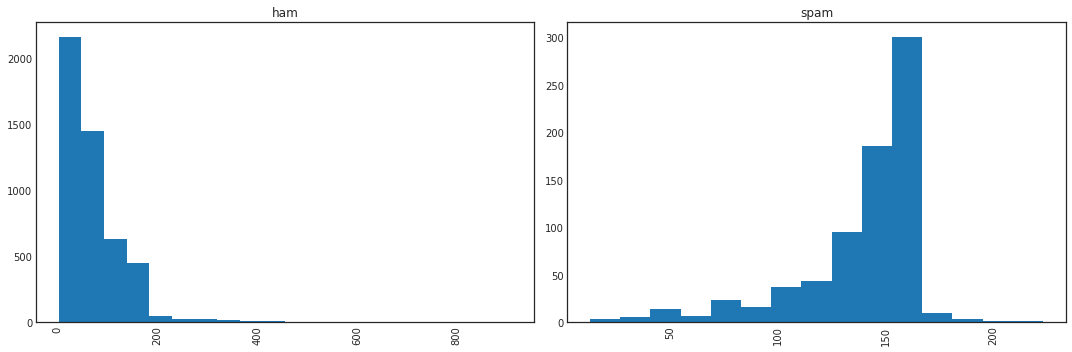

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

sms.hist(column='length', by='label', bins='doane', figsize=(15, 5))
plt.tight_layout()
plt.show()

Even taking into consideration the different scales of the $x$ axes, you can see the difference between the two types of messages. Clearly spam messages tend to be longer than ham messages, love letter notwithstanding.

## Text Pre-processing

We can't do much the text data as-is, although getting the message length was a good start. Machine learning algorithms demand that we transform these strings into numerical vectors. Ther're a few ways to do this, but we'll be using one of the simpler and more common ones: the *bag of words*.

We're about to get into the nitty-gritty of text processing by splitting, joining, and mucking about with lists. It's all inteded to be a learning exercise. In one's day job, there are sophisticated language processing libraries that take care of most of this.

Let's start by importing the `string` library and making a sample message to work with. We'll use our tinkering to build a function that we'll latter `apply` to each message in the dataset.

In [13]:
import string

msg = 'This is sample message. Do you see any punctuation? Of course you see punctuation!'

This library provides a list of ASCII punctuation.

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Let's strip all of the punctuation from that message.

In [15]:
msg = ''.join(char for char in msg if char not in string.punctuation)
msg

'This is sample message Do you see any punctuation Of course you see punctuation'

Let's import the `nltk` library and use it to strip any stopwords. You might have to download some additional files through the library's interface.

In [16]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
msg_sans_sw = [word for word in msg.split() if word not in eng_stopwords]
msg_sans_sw

['This',
 'sample',
 'message',
 'Do',
 'see',
 'punctuation',
 'Of',
 'course',
 'see',
 'punctuation']

That's the first few steps of basic text processing. Like I said, there are libraries that can take of this stuff for you, but it's beneficial to do it by hand until you're familiar with the logic behind it.

Before venturing much deeper, let's formalize the above few steps into a function.

In [17]:
def process(line):
    """
    Prepare a line of text for machine learning algorithms.
    
    Parameters
    ----------
    text : string
        A string of natural language, ideally space-separated.
    stopwords : array_like
        An array of stopwords to be removed from the line.
    punctuation : string, array_like
    
    Returns
    -------
    sans_stops : list
        A list of words from the text, minus punctuation and common stopwords.
            
    """
    
    global stop
    global punc
    
    sans_punct = ''.join([char for char in line if char not in punc])
    sans_stops = [word for word in sans_punct.split() if word not in stop]
    return sans_stops

In [18]:
line = 'This is a GREAT sample text, 123?'
stop = stopwords.words('english')
punc = string.punctuation

process(line)

['This', 'GREAT', 'sample', 'text', '123']


It's important to note that this function does not normalize letter case. Other text processing methods will often convert everything to lower case if that is seen as an irrelevant feature, but when it comes to spam detection, I surmise that case is acutally very important. To make my point, consider a message that starts with "FREE" (in all-caps). That word, especially because it is in all-caps, just screams spam, doesn't it?

## Vectorization

Now we can transform those text messages into a vector format that machine learning algorithms can understand. We'll use the *bag of words* method mentioned before. It works like this:

1. Count how many times a word occurs in each message (term frequency).
1. Weigh the counts, so that freqent words get lower weight (inverse document frequency).
1. Normaliza the vectors to abstract from text length (L2 norm).

We'll use Scikit-Learn's `CountVectorizer` which is able to take a collection of texts as input and return a two-dimensional matrix of token counts. One dimension will comprise the entire vocabulary (the rows in this case) while the individual documents are represented by the other dimension (the columns). It'll look something like this:

|                  | message_1 | message_2| ... | message_n |
| ---------------- | --------- | -------- | --- | --------- |
| word_1_frequency |         0 |        2 |     |         1 |
| word_1_frequency |         0 |        1 |     |         0 |
|              ... |       ... |      ... | ... |       ... |
| word_n_frequency |         1 |        0 |     |         0 |

Not surprisingly this kind of matrix is going to have a looooooot of zeroes. Fortunately, Scikit-Learn is able to implement various kinds of sparse matricies that alleviate the need to watse memory space on giant swaths of nothing.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
bag_transformer = CountVectorizer(lowercase=False, analyzer=process).fit(sms['message'])
type(bag_transformer)

sklearn.feature_extraction.text.CountVectorizer

Although not quite accurate, you can think of this `bag_transformer` as like a design for an empty bag, with many pockets therein that will hold counts of specific words. We'll use this  to `transform()` messages which will produce a complete bag of words.

It actually wasn't necessary to specify `lowercase=False` in the above call, because specifying your own analyzer causes that particular argument to be ignored (as well as some others). I just wanted you to acknowledge that it exists, and that we definitely do want a case-sensitive bag o' words.

So how many unique words are in this bag anyway?

In [21]:
len(bag_transformer.vocabulary_)

11617

Now, let's demonstrate the power of this fully-operational vectorizer on a single message. What message resides at index locations 42?

In [22]:
sample_sms = sms['message'][42]
sample_sms

'07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow'

Now, let's put it through our vectorizer.

In [30]:
sample_bag = bag_transformer.transform([sample_sms])

print(type(sample_bag))
print(sample_bag.shape)
print(sample_bag)

<class 'scipy.sparse.csr.csr_matrix'>
(1, 11617)
  (0, 29)	1
  (0, 54)	1
  (0, 1363)	1
  (0, 2846)	1
  (0, 3356)	1
  (0, 3552)	1
  (0, 4456)	1
  (0, 5467)	2
  (0, 5494)	1
  (0, 6142)	1
  (0, 6891)	2
  (0, 8408)	1
  (0, 8647)	1
  (0, 9541)	1
  (0, 10068)	1
  (0, 10741)	1
  (0, 10830)	1


We can get the words back out of the bag like so:

In [24]:
for w in sample_bag.nonzero()[1]:
    print(bag_transformer.get_feature_names()[w])

07732584351
08000930705
Burns
MSG
Please
Rodger
We
call
camcorder
delivery
free
mobile
nokia
reply
sms
tomorrow
tried


Just like we did with that sample message, we can now `transform()` the entire collection of messages. This might take a few seconds.

In [32]:
sms_bag = bag_transformer.transform(sms['message'])

Here are some descriptives of the sparse matrix we just made.

In [26]:
print(f'Sparse Matrix Shape: {sms_bag.shape}')
print(f'Non-zero Occurences: {sms_bag.nnz}')

sparsity = (100.0 * sms_bag.nnz) / (sms_bag.shape[0] * sms_bag.shape[1])
print(f'Sparsity: {sparsity:1.2f}')

Sparse Matrix Shape: (5572, 11617)
Non-zero Occurences: 56024
Sparsity: 0.09


Now that the counting is finished, weighting and normalization of terms can be accomplished by TD-IDF, which Scikit-Learn does with its `TfidTransformer`.

## TF-IDF

TD-IDF stands for *term frequency-inverse document frequency*. Its weighting is often used in information retrieval and text mining. It is a statistical measure of how important a word is within a document, when that document is also part of a larger corpus. The importance of a word increases with its frequency in a document, but that is balanced by the frequency of word in the whole corpus, which lowers the importance as it occurs. Search engines make use of this when trying to judge how relevant a document is to a query.

Typically two terms are involved in calculating TF-IDF. The first is the normalized term frequency (TF) and the second is inverse document frequency (IDF).

**Term frequency (TF)** is the number of times a term appears in a document divided by the total number of terms in that document.

**Inverse document frequency (IDF)** balances term frequency (which assumes equal importance for all terms) by comparing the number of documents in a corpus with the number of documents that contain the term. Both of those terms are under a log_e.'

**Term frequency-inverse document frequency (TF-IDF)** is the product of TF and IDF.

#### Example

You have a **500** word document that includes the word ***fnord*** **23** times. It is part of a corpus that contains **10,000** documents, of which **7** documents (including the mentioned just above) contain that word. Here is how you would calculate the term frequency of that term, in that document.

$$
\large
\text{term frequency} = 23 \div 500 = 0.046
\\
\large
\text{inverse document frequency} = \log (10,000 \div 7) = 4.9618
\\
\large
\text{tf-idf} = 0.046 \times 4.9618 = \color{red}{0.0093}
$$

Let's see how this is done with Scikit-Learn using that sample bag we made earlier.

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(sms_bag)
sample_tfidf = tfidf_transformer.transform(sample_bag)
print(sample_tfidf)

  (0, 10830)	0.21825402097992086
  (0, 10741)	0.17509730090883832
  (0, 10068)	0.22649706539217168
  (0, 9541)	0.1731301746263505
  (0, 8647)	0.2582576761897893
  (0, 8408)	0.16719063052852873
  (0, 6891)	0.3318667049465819
  (0, 6142)	0.23045790521776877
  (0, 5494)	0.2537672463504903
  (0, 5467)	0.24985079842590838
  (0, 4456)	0.1641314069305411
  (0, 3552)	0.30038592861593333
  (0, 3356)	0.18229872746676004
  (0, 2846)	0.26957265569927513
  (0, 1363)	0.30038592861593333
  (0, 54)	0.2284192040146275
  (0, 29)	0.30038592861593333


That's neat. How about some other words from the whole set?

Here we'll find the IDF of the word *university* in the SMS dataset. The code looks a little funky, so I'll explain it.

The object `tfidf_transformer` is an instance of an `TfidfTransformer`. It has a property called `idf_` which contains the inverse document frequency of every word in the count matrix that has been fit to it, which the SMS dataset bag of words in this case. The bag transformer has a property called `vocabulary_` which is a dictionary wherein the keys are the words and the values are the indices of the words in the document-term matrix (I think). So the code below will return the IDF value at the index of the word *university* as found in the bag_transformer vocabulary dictionary. Hope that was at least minimally clear.

In [74]:
tfidf_transformer.idf_[bag_transformer.vocabulary_['university']]

8.527076498901426

Let's transform the entire corpus.

In [91]:
sms_tfidf = tfidf_transformer.transform(sms_bag)
sms_tfidf.shape

(5572, 11617)

This was just one of many ways to vectorize text data. Getting text ready for data work involves multiple stages of feature engineering and building a *pipeline*.

## Training a Model

Now that we have our SMS corpus in nice and orderly vectorized format, we can finally select and train a machine learning algorithm that will (we hope) predict whether or not a given message is spam. Out of the many models we can choose from, we'll be using a naive Bayes classifier. It's a probabilistic classifier which has been used with great success for decades, especially in text classification tasks. It still remains competitive even against more modern methods, such as support vector machines.

What seems a bit odd with this course is that we'll be passing our tfidf matrix to the naive Bayes classifier, which isn't how I've other guides do it. According to the official docs:

> The multinomial Naive Bayes classifier is suitable for classification with
discrete features (e.g., word counts for text classification). The
multinomial distribution normally requires integer feature counts. **However,
in practice, fractional counts such as tf-idf may also work.**

That's not exactly a ringing endorsement of the method, but YOLO, I guess.

The number of dataframes, matrices, and whatnot are getting out of hand, so I'll review what we're working with.

| name | type | description |
| ---- | ---- | ----------- |
| `sms` | `DataFrame` | A corpus of text messages with the features, `label`, `message`, and `length` |
| `process` | `function` | A function for turning SMS messages into tokens without stopwords|
| `bag_transformer` | `CountVectorizer` | A tool for converting a collection of documents into a matrix of token counts. After fitting a corpus, it contains a vocabulary of all the words in that corpus. |
| `sample_sms` | `str` | A single message taken from row index `42` of the `sms` dataframe. |
| `sample_bag` | `scr_matrix` | A bag of words made from `sample_sms` having been put through `bag_transformer.transform()` |
| `sms_bag` | `scr_matrix` | The bag of words for the entire `sms` dataset having been put through `bag_transformer.transform()` |
| `tfidf_transformer` | `TfidfTransformer` | A tool for converting a count matrix (such as a bag of words) into a normalized tf or tf-idf representation. |
| `sample_tfidf` | `scr_matrix` | A tf-idf representation of `sample_sms` |
| `sms_tfidf` | `scr_matrix` | A tf-idf representation of `sms_bag` |

In [147]:
from sklearn.naive_bayes import MultinomialNB

spam_detection_model = MultinomialNB().fit(sms_tfidf, sms['label'])

So, `spam_detection_model` should have everything necessary to detect speam messages, so long as the messages passed to it are in the form a matrices that are a tf-idf representation.

Let's test it on a single message.

In [149]:
sample_prediction = spam_detection_model.predict(sample_tfidf)[0]
sample_label = sms['label'].iloc[42]
print(f'Model predicted {sample_prediction}, and the real label is {sample_label}')

Model predicted spam, and the real label is spam


It worked! It's barely more scrutable than magic to me, though.

## Model Evaluation

No to put the entire dataset through the model and see how well it performs.

In [161]:
sms_predictions = spam_detection_model.predict(sms_tfidf)
print(','.join(list(p for p in sms_predictions)[:500]))

ham,ham,spam,ham,ham,ham,ham,ham,spam,spam,ham,spam,spam,ham,ham,spam,ham,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,spam,ham,ham,spam,spam,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,spam,ham,ham,ham,spam,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,spam,ham,ham,ham,ham,spam,ham,ham

Scikit-Learn's classification report, which we have used in many other lessons, can be utilized here. It will return the precision, recall, f1-score, and a support column. You've really got to understand those terms.

**Precision** is the ratio of true positives to all positives (both true and false). It is the measure of many selected items are relevant.

**Recall** is the ratio of true positives to all relevant elements (all possible true positives). It is a measure of how many relevant items were selected.

Both precision and recall ought to be maximized towards 1.

In [164]:
from sklearn.metrics import classification_report

print(classification_report(sms['label'], sms_predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.84      0.92       747

avg / total       0.98      0.98      0.98      5572



One thing to get out of the way, and which you might have already noticed, is that we are using the exact same data to train and to test a model. This would **never** be acceptable in a real-world scenario. Putting that aside, let's see what we've got here.

Overall the model looks to perform extremely well. For what amounted to a few hours' work we are able to classify spam and ham messages almost perfectly. But only almost.

The **precision** for ham is 0.98, which means a few spam messages were erroniously classified as ham. The **precision** for spam, on the other hand, is 1.00. That means no ham messages were accidentally tossed into the spam folder.

As for **recall**, the score for ham is 1.00, meaning that all ham was labels correctly for what it was. Spam, however, has a **recall** score of 0.84, which means that not all spam messages were correctly labeled.

## Train Test Split

OK, you know that we should have done this step earlier, but whatever.

In [172]:
from sklearn.model_selection import train_test_split

sms_train, sms_test, label_train, label_test = \
    train_test_split(sms['message'], sms['label'], test_size=0.2)

lengths = (len(x) for x in (sms_train, sms_test, label_train, label_test))
print(tuple(lengths))

(4457, 1115, 4457, 1115)


## Creating a Data Pipeline

Once we have a plan for our data, we can utilize Scikit-learn's pipeline abilites to store a workflow. With this we can set up ahead of time the transformations that we want to use on data that we will get in the future. Pipeline objects use the same interface as any other of Scikit-learn's estimators.

In [182]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bag', CountVectorizer(analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(sms_train, label_train)
predictions = pipeline.predict(sms_test)

print(classification_report(label_test, predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98       989
       spam       0.99      0.72      0.83       126

avg / total       0.97      0.97      0.97      1115

